In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, mapping
from libpysal.weights import KNN
from spreg import ML_Lag
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from esda import Moran

In [2]:
property = gpd.read_file('data/cycle/Market_value_usable_hedonic_data.csv', engine='pyogrio')
canopy = gpd.read_file('data/canopy.gdb', engine='pyogrio')
ta = gpd.read_file('data/chc-boundaries/territorial-authority-2021-generalised.gpkg', engine='pyogrio')
sa2 = gpd.read_file('data/chc-boundaries/sa2/statistical-area-2-2023-generalised.shp')

/Users/rujalshrestha/Projects/chc-property-prices/venv/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


In [3]:
ta_chc = ta[ta['TA2021_V1_00_NAME_ASCII'] == 'Christchurch City']
sa2_chc = gpd.clip(sa2, ta_chc)
boundary = sa2_chc.copy(deep=True)

In [4]:
property.head()

,field_1,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,FullStreetNumber,RoadName,suburb_loc,YearSold,AgeAtSale,GrossSalePrice,...,RnkIMDNoHo,RnkIMDNoHe,RnkIMDNoEd,RnkIMDNoAc,DECILE_high,DECILE_prim,Median_Income,CBD_DIST,Ratio,z_score
0,0,0,0,0,4,Romanee Lane,Wigram,2024,18,920000,...,1516.0,1356.0,1004.0,1313.0,7.0,9.0,92781,6615.87185063722,0.6630434782608695,0.8634969826688191
1,1,2,2,2,52,Sioux Avenue,Wigram,2024,18,670000,...,2136.0,2283.0,2205.0,2014.0,8.0,3.0,92781,6657.46003773288,1.0,0.2064113830650419
2,2,3,3,3,34,Contrail Street,Wigram,2024,18,750000,...,1139.0,1104.0,1035.0,940.0,7.0,7.0,92781,4921.376982828,1.04,0.4166787749382506
3,3,4,4,4,34,Contrail Street,Wigram,2018,13,550000,...,1139.0,1104.0,1035.0,940.0,7.0,7.0,92781,4921.376982828,0.9454545454545454,0.1089897047447711
4,4,6,6,6,38,Keene Street,Wigram,2024,18,795000,...,1618.0,1677.0,1357.0,1468.0,8.0,7.0,92781,5923.28314260674,0.981132075471698,0.5349541828669305


In [5]:
property_2018 = property[(property['YearSold'].isin(['2017', '2018', '2019'])) & (property['LandArea'] != '0.0')]

property_gdf = gpd.GeoDataFrame(
  property_2018,
  geometry = gpd.points_from_xy(property_2018['gd2000co'], property_2018['gd2000_yco']),
  crs=4326
).to_crs(2193)

gdf_chc = gpd.clip(property_gdf, boundary)
canopy_chc = canopy.copy(deep=True)

In [6]:
# gdf_chc = gdf_chc.loc[:, ['GrossSalePrice','AgeAtSale', 'LandArea', 'TotalFloorArea', 'water_DIST', 'bus_DIST', 'Census_Pop', 'RnkIMDNoEm',
#        'RnkIMDNoIn', 'RnkIMDNoCr', 'RnkIMDNoHo', 'RnkIMDNoHe', 'RnkIMDNoEd',
#        'RnkIMDNoAc', 'CBD_DIST', 'geometry']]

gdf_chc = gdf_chc.loc[:, ['GrossSalePrice','AgeAtSale', 'LandArea', 'TotalFloorArea', 'water_DIST', 'bus_DIST', 'Census_Pop', 'RnkIMDNoEm',
       'RnkIMDNoIn', 'RnkIMDNoCr', 'RnkIMDNoHo', 'RnkIMDNoHe', 'RnkIMDNoEd',
       'RnkIMDNoAc', 'DECILE_high', 'DECILE_prim', 'Median_Income', 'CBD_DIST', 'geometry',
       'cycleways_DIST', 'cycle_DENS', 
       # 'on_DIST', 'on_DENS'
       ]]

In [7]:
gdf_chc["buf_20"]  = gdf_chc.geometry.buffer(20)
gdf_chc["buf_50"]  = gdf_chc.geometry.buffer(50)
gdf_chc["buf_100"] = gdf_chc.geometry.buffer(100)
gdf_chc["buf_200"] = gdf_chc.geometry.buffer(200)

def make_buffer_gdf(buf_series):
    return (gpd.GeoDataFrame({"geometry": buf_series}, crs=2193)
              .reset_index()
              .rename(columns={"index": "prop_id"}))

buf20  = make_buffer_gdf(gdf_chc["buf_20"])
buf50  = make_buffer_gdf(gdf_chc["buf_50"])
buf100 = make_buffer_gdf(gdf_chc["buf_100"])
buf200 = make_buffer_gdf(gdf_chc["buf_200"])


def canopy_area_overlay(canopy, buffers):
    inter = gpd.overlay(
        buffers,
        canopy,
        how="intersection",
        keep_geom_type=False
    )
    inter["area"] = inter.geometry.area
    return inter.groupby("prop_id")["area"].sum()

def canopy_area_sjoin(canopy, buffers):
    joined = gpd.sjoin(
        canopy,
        buffers,
        how="inner",
        predicate="intersects"
    )
    joined["area"] = joined.geometry.area
    return joined.groupby("prop_id")["area"].sum()

area_0_20  = canopy_area_overlay(canopy_chc, buf20)
area_0_50  = canopy_area_overlay(canopy_chc, buf50)
area_0_100 = canopy_area_sjoin(canopy_chc, buf100)
area_0_200 = canopy_area_sjoin(canopy_chc, buf200)

gdf_chc["canopy_0_20"]   = gdf_chc.index.map(area_0_20).fillna(0)
gdf_chc["canopy_0_50"]   = gdf_chc.index.map(area_0_50).fillna(0)
gdf_chc["canopy_0_100"]  = gdf_chc.index.map(area_0_100).fillna(0)
gdf_chc["canopy_0_200"]  = gdf_chc.index.map(area_0_200).fillna(0)

gdf_chc["canopy_20_50"]  = gdf_chc["canopy_0_50"] - gdf_chc["canopy_0_20"]
gdf_chc["canopy_50_100"]  = gdf_chc["canopy_0_100"] - gdf_chc["canopy_0_50"]
gdf_chc["canopy_100_200"] = gdf_chc["canopy_0_200"] - gdf_chc["canopy_0_100"]

In [8]:
# gdf_chc['buffer_100m'] = gdf_chc.geometry.buffer(50)

# canopy_4326 = canopy_chc.to_crs(epsg='4326')
# gdf_4326 = gdf_chc.to_crs(epsg='4326')
# gdf_4326['buffer_100m'] = gdf_4326['buffer_100m'].to_crs(4326)

# minx, miny, maxx, maxy = canopy_4326.total_bounds

# lon = (minx + maxx) / 2
# lat = (miny + maxy) / 2
# m = folium.Map(location=(lat, lon), zoom_start=17, tiles=None)

# folium.TileLayer(
#   'cartodbpositron',
#   name='CartoDB Positron'
# ).add_to(m)

# for geom in gdf_4326['buffer_100m']:
#   folium.GeoJson(mapping(geom),
#                  style_function=lambda x: {
#                    'color': 'blue',
#                    'weight': 1,
#                    'fillOpacity': 0.1
#                  }).add_to(m)
  
# for geom in canopy_4326['geometry']:
#   folium.GeoJson(
#     mapping(geom),
#     style_function=lambda x: {
#       'color': 'green',
#       'weight': 1,
#       'fillOpacity': 0.3
#     }
#   ).add_to(m)

# for geom in gdf_4326.geometry:
#   folium.CircleMarker(
#     location=[geom.y, geom.x],
#     radius=3,
#     color='red'
#   ).add_to(m)

# m

In [9]:
gdf_chc.drop(inplace=True, columns=[
  'buffer_100m',
  'buf_20',
  'buf_50',
  'buf_100',
  'buf_200',
  'canopy_0_50',
  'canopy_0_100',
  'canopy_0_200',
  # 'canopy_0_20',
  # 'canopy_20_50',
  # 'canopy_50_100',
  # 'canopy_100_200',
], errors='ignore')

In [10]:
for col in gdf_chc.columns:
  if col != 'geometry':
    gdf_chc[col] = pd.to_numeric(gdf_chc[col], errors='coerce')

In [11]:
# gdf_chc_scaled = gdf_chc[gdf_chc['LandArea'] != 0]
gdf_chc_scaled = gdf_chc.copy(deep=True)
gdf_chc_scaled['log_price'] = np.log(gdf_chc['GrossSalePrice'])

numeric_cols = [
    col for col in gdf_chc_scaled.columns 
    if col not in ["geometry", "GrossSalePrice", "log_price"]
]

for col in numeric_cols:
    gdf_chc_scaled[col] = (gdf_chc_scaled[col] - gdf_chc_scaled[col].mean()) / gdf_chc_scaled[col].std()

In [12]:
X = gdf_chc_scaled[numeric_cols]

X = sm.add_constant(X)

y = gdf_chc_scaled["log_price"]

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     1266.
Date:                Mon, 01 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:06:27   Log-Likelihood:                 3371.2
No. Observations:               12431   AIC:                            -6694.
Df Residuals:                   12407   BIC:                            -6516.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.1505      0.002   7939.469      0.000      13.147      13.154
AgeAtSale         -0.0428      0.002    -21.558      0.000      -0.047      -0.039
LandArea           0.0306      0.002     17.457      0.000       0.027       0.034
TotalFloorArea     0.1769      0.002     86.734      0.000       0.173       0.181
water_DIST         0.0213      0.002     10.613      0.000       0.017       0.025
bus_DIST           0.0164      0.002      8.703      0.000       0.013       0.020
Census_Pop        -0.0037      0.002     -2.153      0.031      -0.007      -0.000
RnkIMDNoEm        -0.1540      0.013    -12.023      0.000      -0.179      -0.129
RnkIMDNoIn        -0.0436      0.014     -3.200      0.001      -0.070      -0.017
RnkIMDNoCr        -0.2257      0.021    -10.877      0.000      -0.266      -0.185
RnkIMDNoHo        -0.2896      0.021    -13.894      0.000      -0.330      -0.249
RnkIMDNoHe        -0.2112      0.013    -15.761      0.000      -0.237      -0.185
RnkIMDNoEd        -0.1149      0.021     -5.382      0.000      -0.157      -0.073
RnkIMDNoAc         0.9649      0.069     13.969      0.000       0.830       1.100
DECILE_high        0.0376      0.002     17.952      0.000       0.033       0.042
DECILE_prim        0.0093      0.002      4.758      0.000       0.005       0.013
Median_Income      0.0491      0.002     20.857      0.000       0.044       0.054
CBD_DIST          -0.0454      0.003    -17.759      0.000      -0.050      -0.040
cycleways_DIST    -0.0178      0.002     -8.016      0.000      -0.022      -0.013
cycle_DENS         0.0110      0.002      4.858      0.000       0.007       0.015
canopy_0_20        0.0094      0.002      4.397      0.000       0.005       0.014
canopy_20_50       0.0121      0.002      5.069      0.000       0.007       0.017
canopy_50_100      0.0024      0.002      1.188      0.235      -0.002       0.006
canopy_100_200     0.0053      0.002      2.720      0.007       0.001       0.009
==============================================================================
Omnibus:                     2861.667   Durbin-Watson:                   1.362
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           154306.131
Skew:                           0.079   Prob(JB):                         0.00
Kurtosis:                      20.259   Cond. No.                         129.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
print(gdf_chc['canopy_0_20'].std())
print(gdf_chc['canopy_20_50'].std())
print(gdf_chc['GrossSalePrice'].mean())

108.50716096423331
481.3270625141229
546944.7268120022


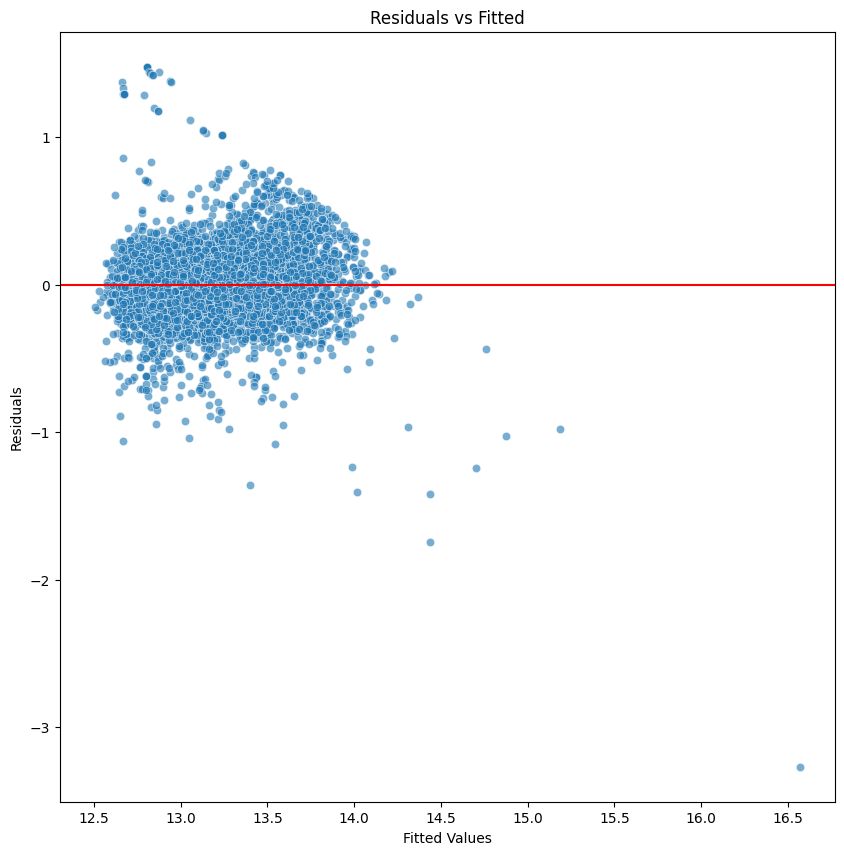

In [14]:
fitted = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(10, 10))
sns.scatterplot(x=fitted, y = residuals, alpha = 0.6)
plt.axhline(0, color='red')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

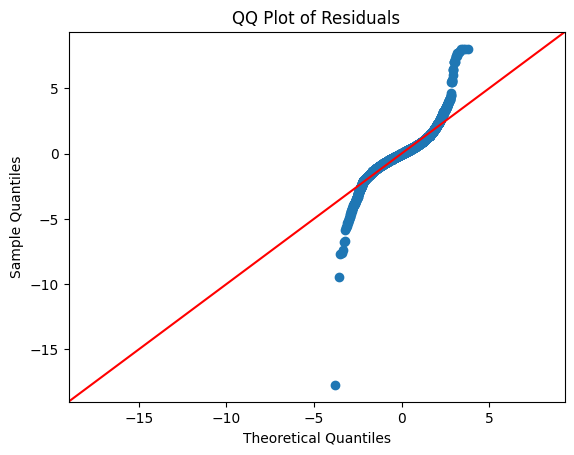

In [15]:
import statsmodels.api as sm
sm.qqplot(model.resid, line="45", fit=True)
plt.title("QQ Plot of Residuals")
plt.show()


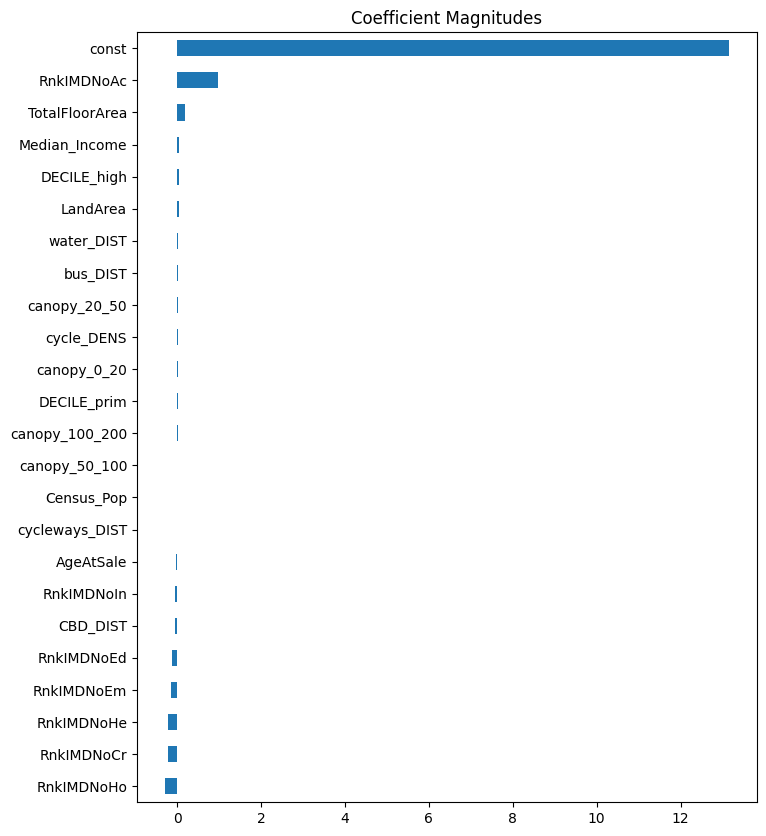

In [16]:
coef = model.params.sort_values()
coef.plot(kind='barh', figsize=(8,10))
plt.title("Coefficient Magnitudes")
plt.show()


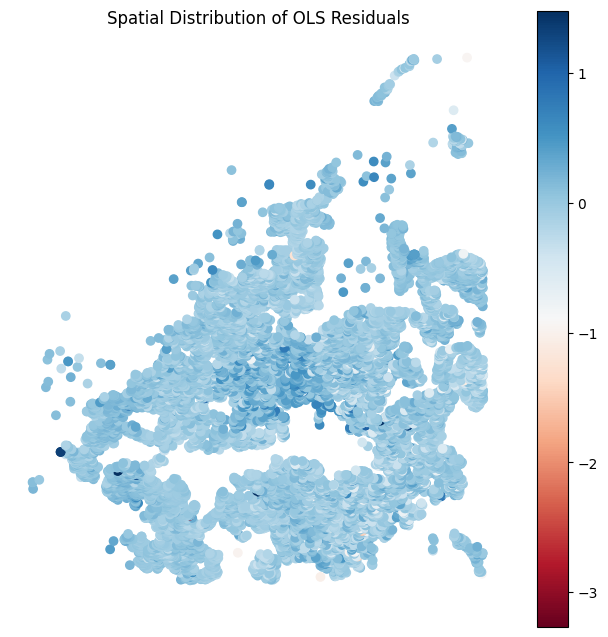

In [17]:
gdf_chc["residuals"] = model.resid
gdf_chc.plot(column="residuals", cmap="RdBu", legend=True, figsize=(8,8))
plt.title("Spatial Distribution of OLS Residuals")
plt.axis("off")
plt.show()


In [18]:
w = KNN.from_dataframe(gdf_chc_scaled, k=8)
w.transform = 'R'

/Users/rujalshrestha/Projects/chc-property-prices/venv/lib/python3.13/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 11 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [19]:
mi = Moran(gdf_chc_scaled['GrossSalePrice'], w)

print("Moran's I: ", mi.I)
print("Expected I: ", mi.EI)
print("p-value: ", mi.p_sim)

Moran's I:  0.6138859706628869
Expected I:  -8.045052292839903e-05
p-value:  0.001


# Moran's I for residuals

In [20]:
gdf_chc.head()

,GrossSalePrice,AgeAtSale,LandArea,TotalFloorArea,water_DIST,bus_DIST,Census_Pop,RnkIMDNoEm,RnkIMDNoIn,RnkIMDNoCr,...,Median_Income,CBD_DIST,geometry,cycleways_DIST,cycle_DENS,canopy_0_20,canopy_20_50,canopy_50_100,canopy_100_200,residuals
1560,610000,24,685.0,211.0,189.601703,216.798910,930.0,1811.0,849.0,1231.0,...,79353,6354.291389,POINT (1564919.129 5174157.305),590.000000,1.6,1.077267,163.500474,3673.623939,10193.360430,0.038369
3842,477500,42,609.0,120.0,139.581200,154.824709,930.0,1811.0,849.0,1231.0,...,79353,6227.397408,POINT (1565047.92 5174178.753),471.071045,1.6,20.957896,450.415001,3568.941048,19805.408025,0.071420
3671,655000,22,704.0,245.0,201.942495,192.941029,930.0,1811.0,849.0,1231.0,...,79353,6352.891850,POINT (1564904.931 5174179.536),610.836121,1.6,10.299413,144.270775,2970.792200,9872.392485,0.009830
3239,500000,44,869.0,131.0,157.854014,179.645498,930.0,1811.0,849.0,1231.0,...,79353,6229.065719,POINT (1565029.188 5174201.753),483.016235,1.6,74.306779,392.823676,3602.928325,19098.845813,0.079604
3781,880000,22,1149.0,279.0,199.693219,216.730600,930.0,1811.0,849.0,1231.0,...,79353,6258.811869,POINT (1564988.184 5174211.698),533.936462,1.6,0.000000,279.813206,6163.843751,14113.518330,0.190113


In [21]:
gdf_chc_scaled['residuals'] = model.resid

mi_res = Moran(gdf_chc_scaled['residuals'], w)

print("Residual Moran's I:", mi_res.I)
print("Expected I:", mi_res.EI)
print("p-value:", mi_res.p_sim)

Residual Moran's I: 0.2972098401536537
Expected I: -8.045052292839903e-05
p-value: 0.001


In [22]:
gdf_chc['residuals'] = model.resid

In [ ]:
# gdf_chc.to_file('output/hedonic_gdf.gpkg')